# 14 - Extracting a sourcelist

This notebook demonstrates how to grab 1D aperture summed HETDEX spectra for an input of ID, RA and DEC using the `Extract` Class API from `HETDEX_API`. This can be done most directly using the command line tool `get_spec.py`. It can be used both interactively on a compute node via `idev` or through a jupyter notebook as shown here, as well as within a slurm job file. We show you here how to do both.

Examples of what you might like to do with the spectra afterwards is shown later. For example the spectra produced from get_spec.py can be translated to line intensities, or approximate pass-band magnitudes with a few extra steps.

#### Import all necessary python packages. 
These are mainly for working within the notebook. The command line tools described have the necessary preamble built in.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# either point to your HETDEX_API path (you will need to git pull) or use Erin's
import sys
sys.path.append('/work/05350/ecooper/stampede2/HETDEX_API')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from input_utils import setup_logging
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table, join

from hetdex_api.extract import Extract
from hetdex_api.survey import Survey
from hetdex_api.shot import *

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


# IMPORTANT NOTE OF CAUTION WITH RUNNING ON TACC!!!

Because this script involves opening the Fibers class object which contains all fiber spectra from a 3 dither observation, you will be pulling in a lot of memory for each shot that is open. **NEVER** run this script from a login node on TACC. A login node is a node you access when you ssh in. 

You need to request a compute node instead by either 

(1) using the idev command :

`idev -p skx-dev `

if it works on a small catalog, you can always run interactively using a longer queue option

`idev -p skx-normal` 

(2) using a jupyter notebook 

(3) or by submitting the job into the slurm job scheduler (generally if you are working on more than ~200 shots

## Getting all spectra at a specified RA/DEC. This will search through all shots in HDR1

If a shotid is not specified the program will search for any shot within HDR1 that overlaps within an 11 arcmin radius of the input coordinates. Because of the non-contiguous VIRUS footprint, there is no guarantee the aperture defined by the input ra/dec/rad will contain enough fibers to do a measurement. The aperture radius is 3" by default or can be specified with the --rad argument. Use the --outfile argument to label the output pickle file. Otherwise the default 'output.pkl' will be used.

You can run these commands from the command line by removing the "!" command but be sure you are on a compute node by calling `idev` first.

In [5]:
!python3 /work/05350/ecooper/stampede2/HETDEX_API/get_spec.py --ra 150.02548 --dec 2.087987 --ID cosmos_LAE --outfile cosmos_LAE

[INFO - 2019-10-17 11:22:36,897] Extracting for ID: cosmos_LAE
[INFO - 2019-10-17 11:22:36,919] Searching through all shots
[INFO - 2019-10-17 11:22:36,919] Finding shots of interest
[INFO - 2019-10-17 11:22:38,610] Number of shots of interest: 18
[INFO - 2019-10-17 11:22:38,611] Extracting 18 sources
[INFO - 2019-10-17 11:22:38,627] Working on shot: 20170105009
[WARNING - 2019-10-17 11:22:46,537] Not enough fibers found within radius to do an extraction
[INFO - 2019-10-17 11:22:46,542] Working on shot: 20170106001
[WARNING - 2019-10-17 11:22:53,969] Not enough fibers found within radius to do an extraction
[INFO - 2019-10-17 11:22:53,974] Working on shot: 20170106002
[WARNING - 2019-10-17 11:23:01,405] Not enough fibers found within radius to do an extraction
[INFO - 2019-10-17 11:23:01,409] Working on shot: 20170106003
[WARNING - 2019-10-17 11:23:08,870] Not enough fibers found within radius to do an extraction
[INFO - 2019-10-17 11:23:08,875] Working on shot: 20170107012
[WARNING - 

## Speed things up using multiprocessing

You can speed up processes (by up to ~30x) with python multiprocessing if you are working interactively in a notebook or in an idev session (**NEVER FROM A LOGIN NODE**). Use the multiprocessing option with the argument -mp True or --multiprocess True 

In [4]:
!python3 /work/05350/ecooper/stampede2/HETDEX_API/get_spec.py --multiprocess -ra 150.02548 -dec 2.087987 -id mptest -o mptest

[INFO - 2019-10-17 11:42:59,788] Extracting for ID: mptest
[INFO - 2019-10-17 11:42:59,810] Searching through all shots
[INFO - 2019-10-17 11:42:59,810] Finding shots of interest
[INFO - 2019-10-17 11:43:01,535] Number of shots of interest: 18
[INFO - 2019-10-17 11:43:01,535] Extracting 18 sources
[INFO - 2019-10-17 11:43:01,572] Working on shot: 20170105009
[INFO - 2019-10-17 11:43:01,573] Working on shot: 20170106001
[INFO - 2019-10-17 11:43:01,575] Working on shot: 20170106002
[INFO - 2019-10-17 11:43:01,577] Working on shot: 20170106003
[INFO - 2019-10-17 11:43:01,580] Working on shot: 20170107012
[INFO - 2019-10-17 11:43:01,583] Working on shot: 20170107013
[INFO - 2019-10-17 11:43:01,584] Working on shot: 20171220015
[INFO - 2019-10-17 11:43:01,586] Working on shot: 20171221016
[INFO - 2019-10-17 11:43:01,588] Working on shot: 20171222013
[INFO - 2019-10-17 11:43:01,590] Working on shot: 20171225015
[INFO - 2019-10-17 11:43:01,593] Working on shot: 20180110021
[INFO - 2019-10-17 

## Save output as individual astropy tables for each ID/shot combination:

If you prefer to save each spectra to a table, you can do this. We don't recommend this for large numbers of data, but understand that sometimes its easy to start with a readable table. The tables will be stored in the files named `spec_[ID]_[shotid].tab`

In [5]:
!python3 /work/05350/ecooper/stampede2/HETDEX_API/get_spec.py --multiprocess --single -ra 150.02548 -dec 2.087987 -id cosmos_lae

[INFO - 2019-10-17 11:43:41,011] Extracting for ID: cosmos_lae
[INFO - 2019-10-17 11:43:41,029] Searching through all shots
[INFO - 2019-10-17 11:43:41,029] Finding shots of interest
[INFO - 2019-10-17 11:43:42,697] Number of shots of interest: 18
[INFO - 2019-10-17 11:43:42,697] Extracting 18 sources
[INFO - 2019-10-17 11:43:42,734] Working on shot: 20170105009
[INFO - 2019-10-17 11:43:42,736] Working on shot: 20170106001
[INFO - 2019-10-17 11:43:42,738] Working on shot: 20170106002
[INFO - 2019-10-17 11:43:42,739] Working on shot: 20170106003
[INFO - 2019-10-17 11:43:42,741] Working on shot: 20170107012
[INFO - 2019-10-17 11:43:42,742] Working on shot: 20170107013
[INFO - 2019-10-17 11:43:42,745] Working on shot: 20171220015
[INFO - 2019-10-17 11:43:42,750] Working on shot: 20171225015
[INFO - 2019-10-17 11:43:42,750] Working on shot: 20171221016
[INFO - 2019-10-17 11:43:42,751] Working on shot: 20171222013
[INFO - 2019-10-17 11:43:42,753] Working on shot: 20180110021
[INFO - 2019-10

## Getting all spectra at a specified RA/DEC in a specific OBSERVATION/SHOT

Perhaps you only want to focus on a specific shot. Then you can use the -s argument to put the shotid either as an interger value 'YYYYMMDDOBS'= 20190104008 or as a str '20190104v009'. Note if you don't give an --ID option the default is 'DEX'

This is a command line routine so remove the "!" if you are running in a terminal.

In [6]:
!python3 /work/05350/ecooper/stampede2/HETDEX_API/get_spec.py -ra 8.86535 -dec 0.59352  -s 20190104008 -o 20190104008

[INFO - 2019-10-17 11:44:10,277] Extracting for ID: DEX_8.86535_0.59352
[INFO - 2019-10-17 11:44:10,295] Finding shots of interest
[INFO - 2019-10-17 11:44:10,297] Number of shots of interest: 1
[INFO - 2019-10-17 11:44:10,297] Extracting 1 sources
[INFO - 2019-10-17 11:44:10,298] Working on shot: 20190104008
[INFO - 2019-10-17 11:47:59,833] Extracting DEX_8.86535_0.59352


This is particularly helpful if you plan to submit each shot as a separate task. For this reason, I suggest changing the default --outfile option to -o 20190104008 to create the output pickle file 20190104008

## Work on a list of ID/RA/DECs

This can either be a saved astropy table, or an space delimited text file with 3 columns where the columns are ID, RA, DEC. If you want more functionality with your input catalog, just talk to Erin. Note that running this job will take about 30 minutes so only execute if you want to wait around to explore the output.

In [ ]:
!cp /work/05350/ecooper/stampede2/3dhst/3dhst_input.cat .

In [ ]:
!python3 /work/05350/ecooper/stampede2/HETDEX_API/get_spec.py --multiprocess -i '3dhst_input.cat' -o '3dhst' 

## Example Batch Job production

To help those with lists that need to access more than ~200 shots here is an example of how you can break down extractions into several slurm tasks giving each shot a separate process. First use the `get_shots_of_interest.py` function to retrieve a text list of SHOTIDs stored in the file `shotlist` in the working directory.

In [ ]:
! python3 /work/05350/ecooper/stampede2/HETDEX_API/get_shots_of_interest.py -i '3dhst_input.cat'

Then port each python get_spec.py command into a shell script for batch processing using the handy unix program `awk`:

In [ ]:
! awk '{print "python3 /work/05350/ecooper/stampede2/HETDEX_API/get_spec.py -i 3dhst_input.cat -s", $1, "-o", $1}' shotlist > run_shot

Then use `jobsplitter_stampede2` to split the processes into files of 192 jobs each. This will distribute the processes across the cluster giving each node 48 processes to run. Each slurm job in this case will use 4 Nodes. These are all options that you can give the slurm launcher, but we have found its better to limit Nodes =< 4 and time to less than 30 min if you don't want to wait forever to get in the queue. 

In [ ]:
! /work/05350/ecooper/stampede2/HETDEX_API/hdr1_bash_scripts/jobsplitter_stampede2 run_shot 128 1 '00:30:00' 

To run the batch jobs, go to a login node in the working directory (on /work) that contains your input catalog and enter:
    
`sbatch run_shot_1.batch`

`sbatch run_shot_2.batch`


Then you need to combine all the files together to make for easier analysis:

In [ ]:
! python3 /work/05350/ecooper/stampede2/HETDEX_API/get_spec.py --merge True --outfile '3dhst_master'

# Reading in the output

Although it may not be immediately familiar to us astronomers who love fits files, the easiest way to take a bunch of extracted spectra and do something with it is to store it an intermediate binary file which will preserve the nested dictionary format of the output. It means less files produced and less storage space used. 

In [7]:
Sources = pickle.load( open( 'cosmos_LAE.pkl', 'rb'))
#Sources = pickle.load( open( 'mptest.pkl', 'rb'))
#Sources = pickle.load( open( '3dhst.pkl', 'rb'))

8


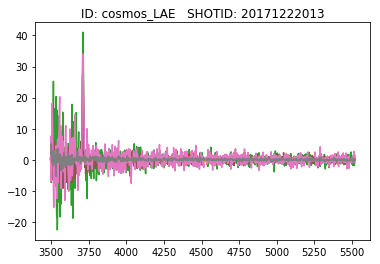

In [8]:
wave = 2.0 * np.arange(1036) + 3470.
count = 0
for id in Sources.keys():
    for shotid in Sources[id].keys():
        plt.plot(wave, Sources[id][shotid][0])
        plt.title('ID: '+str(id)+'   SHOTID: ' + str(shotid))
        count += 1
print(count)

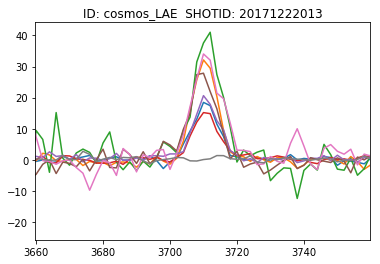

In [9]:
# zoom on emission line
wave_obj = 3709.74
for id in Sources.keys():
    for shotid in Sources[id].keys():
        plt.xlim([ wave_obj - 50, wave_obj + 50])
        plt.plot(wave, Sources[id][shotid][0])
        plt.title('ID: '+str(id)+'  SHOTID: ' + str(shotid))  

## Example Line Fitting

Below I show an example of how to fit a line in a region where you think a line might be. There are other tools you can use to find lines, please read up on specutils.

In [10]:
#
from astropy.modeling import models
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import equivalent_width
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region

In [11]:
def line_fit(obj, wave_obj, datevobs):
    spectrum = Spectrum1D( flux = Sources[obj][datevobs][0]*u.erg * u.cm**-2 / u.s / u.AA, 
                        spectral_axis= (2.0 * np.arange(1036) + 3470.)*u.AA)
    
    sub_region = SpectralRegion((wave_obj-10)*u.AA, (wave_obj+10)*u.AA)
    
    sub_spectrum = extract_region(spectrum, sub_region)

    line_param =  estimate_line_parameters(sub_spectrum, models.Gaussian1D())
    print(line_param.amplitude.value, line_param.fwhm.value)
#    if (line_param.amplitude.value > 0) & (line_param.fwhm.value <10):
    plt.figure()
    plt.plot(spectrum.spectral_axis, spectrum.flux)
    plt.title('ID: '+ str(obj) + '   ObsID: '+ str(datevobs))
    plt.xlim([ wave_obj - 50, wave_obj + 50])
    plt.xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.unit))
    plt.ylabel('Flux Axis({})'.format(spectrum.flux.unit))
    plt.savefig('spec_' + str(obj) + '_' + str(datevobs) + '.png')
    #plt.ylabel('1e-17 ergs/s/cm^2/A')

In [12]:
#wave_obj = 5394.
wave_obj = 3709.74

18.461862725613063 23.548200450309494
32.116579137927836 23.548200450309494
41.02169649744172 18.838560360247595
15.176776386316 23.548200450309494
20.63794886038528 18.838560360247595
27.83804917556706 23.548200450309494
34.035537208281795 28.25784054037139
1.3501259036506956 9.419280180123797


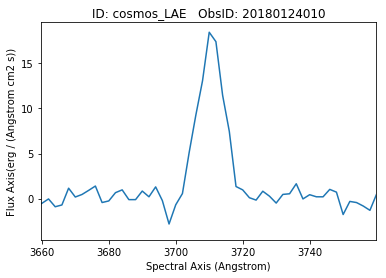

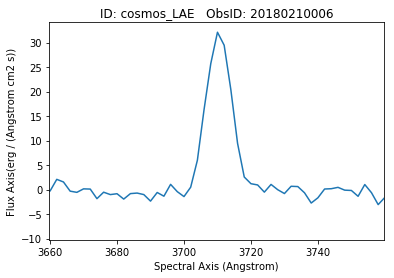

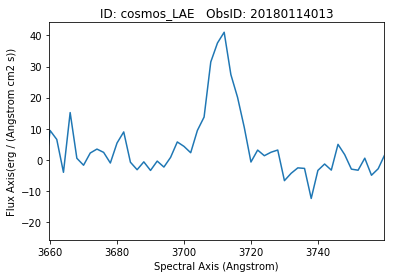

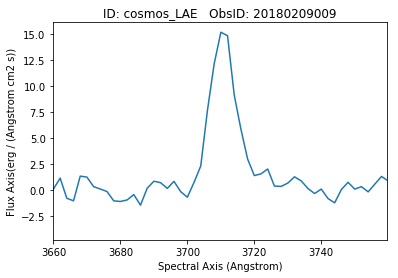

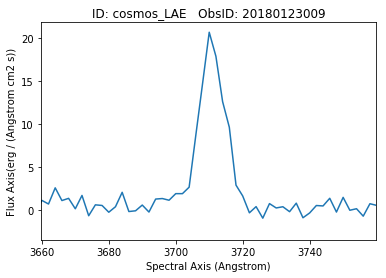

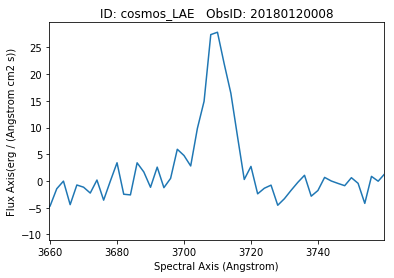

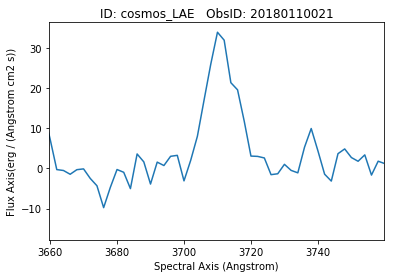

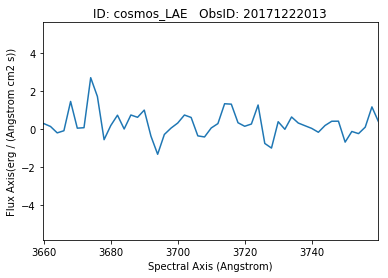

In [13]:
count = 0
for obj in Sources.keys():
    for datevobs in Sources[obj].keys():
        count += 1
        line_fit( obj, wave_obj, datevobs) # note could use multiprocessing Pool to really speed this up

## Approximate magnitude from spectrum and an example of running slurm jobs

This is how a took the pickle output from fitting 9K SDSS stars and calculated the gmagnitude from the 1D spectrum. 

In [14]:
import speclite
import speclite.filters

For an example of how extractions were performed, you can see the directory:
    
    /work/05350/ecooper/stampede2/sdss_comps/test_4nodes
    
The main process list is here:

    /work/05350/ecooper/stampede2/sdss_comps/test_4nodes/run_shot
    
Which then was broken into several slurm jobs that I submitted one at a time (I found sending too, slowed my time to get in the queue as well as processing time greatly:

    /work/05350/ecooper/stampede2/sdss_comps/test_4nodes/run_shot_X.run

Each job is run with:

    sbatch run_shot_X.slurm
    
After all the jobs are complete, I combined all the pickle files together using the merge option within this directory:

    python3 /work/05350/ecooper/stampede2/HETDEX_API/get_spec.py --merge True --outfile sdss_master

Then you load the pickle and the input catalog as that has the SDSS g-mags. 

In [14]:
sdss_table = Table.read('/work/05350/ecooper/stampede2/sdss_comps/test_4nodes/sdss_star.cat', format='ascii')

In [15]:
Sources = pickle.load( open( '/work/05350/ecooper/stampede2/sdss_comps/test_4nodes/sdss_master.pkl', 'rb'))

In [16]:
out_table = Table(names=['ID','shotid','gmag_hetdex'], dtype=['<i8','<i8', '<f'])

filt = speclite.filters.load_filters('sdss2010-g')
wave_rect = 2.0 * np.arange(1036) + 3470.

for ID in Sources.keys():
    for shotid in Sources[ID].keys():
        spec = Sources[ID][shotid][0]

        sel = np.isfinite(spec)
        
        if np.sum(sel) > 0:
            flux, wlen = filt.pad_spectrum( np.array( (1.e-17) * spec[sel]),
                                            np.array(wave_rect[sel]))
        else:
            flux, wlen = filt.pad_spectrum( np.array( (1.e-17) * spec),
                                            np.array(wave_rect))
#        plt.plot(wlen, flux)

        gmag = filt.get_ab_magnitudes(flux, wlen)[0][0] - filt.get_ab_maggies(flux, wlen)[0][0]
#        spec_err = np.sqrt( np.sum( ( Sources[ID][shotid[1]])**2 ))
        out_table.add_row([ID, shotid, gmag])

Here's an example comparison plot using 

In [17]:
combined_table = join(out_table, sdss_table, keys='ID')
sel = (combined_table['g'] > 0) * (combined_table['gmag_hetdex'] > 0)

Text(0.5, 1.0, 'n_stars = 8903')

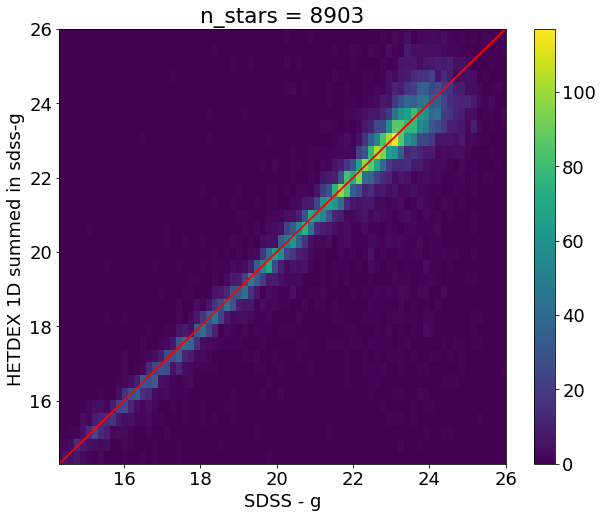

In [18]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8))
plt.plot(np.arange(13,28), np.arange(13,28), color='r')
sel = (combined_table['g'] > 0) * (combined_table['gmag_hetdex'] > 0)
n = np.sum(sel)
plt.hist2d(combined_table['g'][sel], combined_table['gmag_hetdex'][sel], bins=75)
plt.plot(np.arange(13,28), np.arange(13,28), color='r')
plt.xlabel('SDSS - g')
plt.ylabel('HETDEX 1D summed in sdss-g ')
plt.xlim(14.3, 26)
plt.ylim(14.3, 26)
plt.colorbar()
plt.title('n_stars = '+ str(n))
#plt.savefig('sdss_gmag_comps.png')